### Курсовая работа

Задание по итогам курса

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты.
На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.
Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.

*(Усложненное задание) Все тоже самое, но воспользоваться этим датасетом:
https://fitnessallyapp.com/datasets/jester/v1

In [ ]:
import cv2
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

import os
import csv
import glob
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable

from PIL import Image

Из большого датасета возьму только несколько классов

In [119]:
LABELS = {
    "Swiping Right": 0,
    "Swiping Right": 1,
    "No gesture": 2,
    "Thumb Up": 3,
}
digit_to_classname = {0:'Swiping Right', 1:'Swiping Right', 2:'No gesture', 3:'Thumb Up'}

### Отрисовка всех классов

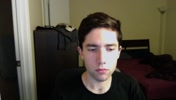

KeyboardInterrupt: 

In [19]:
from IPython import display
from IPython.display import HTML

images = os.listdir(BASE_PATH + '/20bn-jester-v1/136859/')
images2 = os.listdir(BASE_PATH + '/20bn-jester-v1/68574/')
images3 = os.listdir(BASE_PATH + '/20bn-jester-v1/20706/')
images4 = os.listdir(BASE_PATH + '/20bn-jester-v1/62818/')

while True:
    for f in images:
        display.clear_output(wait=True)
        display.display(Image(filename=BASE_PATH + '/20bn-jester-v1/136859/'+f))
        display.display(HTML('<h3>Thumb Up</h3>'))
        time.sleep(0.1)
    for f in images2:
        display.clear_output(wait=True)
        display.display(Image(filename=BASE_PATH + '/20bn-jester-v1/68574/'+f))
        display.display(HTML('<h3>Swiping Right</h3>'))
        time.sleep(0.1)
    for f in images3:
        display.clear_output(wait=True)
        display.display(Image(filename=BASE_PATH + '/20bn-jester-v1/20706/'+f))
        display.display(HTML('<h3>No gesture</h3>'))
        time.sleep(0.1)
    for f in images4:
        display.clear_output(wait=True)
        display.display(Image(filename=BASE_PATH + '/20bn-jester-v1/62818/'+f))
        display.display(HTML('<h3>Swiping Left</h3>'))
        time.sleep(0.1)

In [98]:
from collections import namedtuple

ListDataJpeg = namedtuple('ListDataJpeg', ['id', 'label', 'path'])

class JpegDataset(object):

    def __init__(self, csv_path_input, csv_path_labels, data_root):
        self.classes = self.read_csv_labels(csv_path_labels)
        self.classes_dict = self.get_two_way_dict(self.classes)
        self.csv_data = self.read_csv_input(csv_path_input, data_root)

    def read_csv_input(self, csv_path, data_root):
        csv_data = []
        with open(csv_path) as csvfile:
            csv_reader = csv.reader(csvfile, delimiter=';')
            for row in csv_reader:
                item = ListDataJpeg(row[0],
                                    row[1],
                                    os.path.join(data_root, row[0])
                                    )
                if row[1] in self.classes:
                    csv_data.append(item)
        return csv_data

    def read_csv_labels(self, csv_path):
        classes = []
        with open(csv_path) as csvfile:
            csv_reader = csv.reader(csvfile)
            for row in csv_reader:
                classes.append(row[0])
        return classes

    def get_two_way_dict(self, classes):
        classes_dict = {}
        for i, item in enumerate(classes):
            classes_dict[item] = i
            classes_dict[i] = item
        return classes_dict

In [99]:
IMG_EXTENSIONS = ['.jpg', '.JPG', '.jpeg', '.JPEG']


def default_loader(path):
    return Image.open(path).convert('RGB')


class VideoFolder(torch.utils.data.Dataset):

    def __init__(self, root, csv_file_input, csv_file_labels, clip_size,
                 nclips, step_size, is_val, transform=None,
                 loader=default_loader):
        self.dataset_object = JpegDataset(csv_file_input, csv_file_labels, root)

        self.csv_data = self.dataset_object.csv_data
        self.classes = self.dataset_object.classes
        self.classes_dict = self.dataset_object.classes_dict
        self.root = root
        self.transform = transform
        self.loader = loader

        self.clip_size = clip_size
        self.nclips = nclips
        self.step_size = step_size
        self.is_val = is_val

    def __getitem__(self, index):
        item = self.csv_data[index]
        img_paths = self.get_frame_names(item.path)

        imgs = []
        for img_path in img_paths:
            img = self.loader(img_path)
            img = self.transform(img)
            imgs.append(torch.unsqueeze(img, 0))

        target_idx = self.classes_dict[item.label]

        # format data to torch
        data = torch.cat(imgs)
        data = data.permute(1, 0, 2, 3)
        return (data, target_idx)

    def __len__(self):
        return len(self.csv_data)

    def get_frame_names(self, path):
        frame_names = []
        for ext in IMG_EXTENSIONS:
            frame_names.extend(glob.glob(os.path.join(path, "*" + ext)))
        frame_names = list(sorted(frame_names))
        num_frames = len(frame_names)

        # set number of necessary frames
        if self.nclips > -1:
            num_frames_necessary = self.clip_size * self.nclips * self.step_size
        else:
            num_frames_necessary = num_frames

        # pick frames
        offset = 0
        if num_frames_necessary > num_frames:
            # pad last frame if video is shorter than necessary
            frame_names += [frame_names[-1]] * (num_frames_necessary - num_frames)
        elif num_frames_necessary < num_frames:
            # If there are more frames, then sample starting offset
            diff = (num_frames - num_frames_necessary)
            # Temporal augmentation
            if not self.is_val:
                offset = np.random.randint(0, diff)
        frame_names = frame_names[offset:num_frames_necessary +
                                  offset:self.step_size]
        return frame_names

In [100]:
transform = tt.Compose([
        tt.CenterCrop(84),
        tt.ToTensor(),
        tt.Normalize(mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225])
    ])

In [101]:
train_data = VideoFolder(root="./data/20bn-jester-v1-short",
                             csv_file_input='./data/jester-v1-train-short.csv',
                             csv_file_labels="./data/jester-v1-labels-short.csv",
                             clip_size=18,
                             nclips=1,
                             step_size=2,
                             is_val=False,
                             transform=transform,
                             )
train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=10, shuffle=True,
        num_workers=0, pin_memory=True,
        drop_last=True)

In [102]:
len(train_loader)

1689

In [103]:
val_data = VideoFolder(root="./data/20bn-jester-v1-short",
                           csv_file_input="./data/jester-v1-validation-short.csv",
                           csv_file_labels="./data/jester-v1-labels-short.csv",
                           clip_size=18,
                           nclips=1,
                           step_size=2,
                           is_val=True,
                           transform=transform,
                           )

val_loader = torch.utils.data.DataLoader(
        val_data,
        batch_size=10, shuffle=False,
        num_workers=0, pin_memory=True,
        drop_last=False)

In [104]:
class ConvColumn(nn.Module):

    def __init__(self, num_classes):
        super(ConvColumn, self).__init__()

        self.conv_layer1 = self._make_conv_layer(3, 64, (1, 2, 2), (1, 2, 2))
        self.conv_layer2 = self._make_conv_layer(64, 128, (2, 2, 2), (2, 2, 2))
        self.conv_layer3 = self._make_conv_layer(
            128, 256, (2, 2, 2), (2, 2, 2))
        self.conv_layer4 = self._make_conv_layer(
            256, 256, (2, 2, 2), (2, 2, 2))

        self.fc5 = nn.Linear(12800, 512)
        self.fc5_act = nn.ELU()
        self.fc6 = nn.Linear(512, 4)

    def _make_conv_layer(self, in_c, out_c, pool_size, stride):
        conv_layer = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_c),
            nn.ELU(),
            nn.MaxPool3d(pool_size, stride=stride, padding=0)
        )
        return conv_layer

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)

        x = x.view(x.size(0), -1)

        x = self.fc5(x)
        x = self.fc5_act(x)

        x = self.fc6(x)
        return x

In [105]:
device = torch.device('cpu')

In [106]:
model = ConvColumn(4)
model

ConvColumn(
  (conv_layer1): Sequential(
    (0): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False

In [107]:
criterion = nn.CrossEntropyLoss().to(device)

In [108]:
#define optimizer
epochs = 3
max_lr = 0.008
lr = 0.001
last_lr = 0.00001
momentum = 0.9
weight_decay = 0.00001
optimizer = torch.optim.SGD(model.parameters(), lr,
                                momentum=momentum,
                                weight_decay=weight_decay)

In [109]:
print(torch.__version__)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

1.6.0


In [114]:
#epoch_losses = []

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = Variable(data), Variable(labels)
        #data = data.cuda()
        #labels = labels.cuda()
        
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 100 == 99:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/100}')
            time2 = time.time()
            print(f'Spend time for 100 image\\\{time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

Train Epoch: 1, Loss: 0.26934595329687
Spend time for 100 image\\1488.518367767334 sec
Train Epoch: 1, Loss: 0.2713235933892429
Spend time for 100 image\\1497.2618458271027 sec
Train Epoch: 1, Loss: 0.24831831659190357
Spend time for 100 image\\1498.301724433899 sec
Train Epoch: 1, Loss: 0.28813568005338314
Spend time for 100 image\\1502.8221185207367 sec
Train Epoch: 1, Loss: 0.24045562885701657
Spend time for 100 image\\1514.1790232658386 sec
Train Epoch: 1, Loss: 0.23529196393676102
Spend time for 100 image\\1507.360762834549 sec
Train Epoch: 1, Loss: 0.2706247170269489
Spend time for 100 image\\1509.9908180236816 sec
Train Epoch: 1, Loss: 0.27925469645299017
Spend time for 100 image\\1508.2095522880554 sec
Train Epoch: 1, Loss: 0.26760224368423224
Spend time for 100 image\\1503.4406611919403 sec
Train Epoch: 1, Loss: 0.29440789749845864
Spend time for 100 image\\1507.4525842666626 sec
Train Epoch: 1, Loss: 0.2732845742907375
Spend time for 100 image\\1512.9527401924133 sec
Train Ep

Text(0.5, 1.0, 'losses vs. No. of epochs')

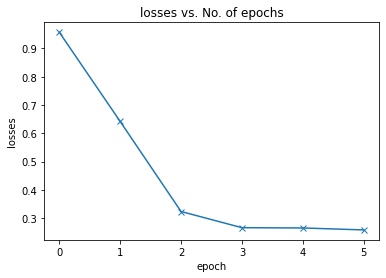

In [115]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [116]:
torch.save(model.state_dict(), './models/proba3.pth')

In [138]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return digit_to_classname[category_i], category_i

In [136]:
#total = 0
right = 0
counter = 0
with torch.no_grad():
    for i, data in enumerate(val_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)   
        output = model(inputs)
        guess, guess_i = categoryFromOutput(output)
        category = digit_to_classname[int(labels[0])]
        
        if guess == category:
            right = right + 1
        print(counter, right)


print('Accuracy of the network:  ',  (100 * right / counter))

1 1
2 1
3 2
4 3
5 4
6 5
7 6
8 7
9 8
10 9
11 10
12 11
13 12
14 13
15 14
16 15
17 16
18 17
19 18
20 19
21 20
22 21
23 22
24 23
25 23
26 23
27 24
28 25
29 26
30 26
31 27
32 27
33 28
34 29
35 30
36 31
37 32
38 33
39 34
40 35
41 36
42 37
43 38
44 38
45 39
46 40
47 41
48 42
49 43
50 44
51 45
52 46
53 46
54 47
55 48
56 49
57 50
58 51
59 52
60 53
61 54
62 55
63 56
64 57
65 58
66 59
67 60
68 61
69 61
70 62
71 63
72 64
73 65
74 66
75 67
76 68
77 69
78 69
79 70
80 71
81 72
82 73
83 74
84 75
85 76
86 77
87 78
88 79
89 80
90 81
91 82
92 82
93 83
94 84
95 85
96 86
97 86
98 87
99 87
100 88
101 89
102 90
103 91
104 91
105 92
106 93
107 94
108 95
109 96
110 97
111 98
112 99
113 100
114 101
115 102
116 103
117 104
118 105
119 105
120 106
121 107
122 107
123 108
124 109
125 110
126 111
127 112
128 112
129 113
130 114
131 115
132 116
133 117
134 118
135 119
136 120
137 121
138 122
139 123
140 124
141 125
142 125
143 126
144 127
145 128
146 129
147 130
148 131
149 132
150 133
151 134
152 135
153 136
154 13

In [137]:
model.eval()

ConvColumn(
  (conv_layer1): Sequential(
    (0): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False

In [143]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN

# Создаем объект для считывания потока с веб-камеры(обычно вебкамера идет под номером 0. иногда 1)
cap = cv2.VideoCapture(0)  

# Класс детектирования и обработки лица с веб-камеры 
class GestureDetector(object):

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = ConvColumn(4).to(self.device)
        self.emodel.load_state_dict(torch.load('./models/proba3(1-6).pth'))
        self.emodel.eval()

    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, boxes, probs, landmarks):
        try:
            for box, prob, ld in zip(boxes, probs, landmarks):
                # Рисуем обрамляющий прямоугольник лица на кадре
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                # пишем на кадре какая эмоция распознана
                #cv2.putText(frame, 
                #    emotion, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Рисуем особенные точки
                #cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                #cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                #cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                #cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                #cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            print('Something wrong im draw function!')

        return frame
    
    # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
    
    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            return 'Swiping Right'
        elif digit == 1:
            return 'Swiping Left'
        elif digit == 2:
            return 'No gesture'
        elif digit == 3:
            return 'Thumb Up'
       
    # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):              
        # Заходим в бесконечный цикл
        while True:
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
            ret, frame = cap.read()
            try:
                # детектируем расположение лица на кадре, вероятности на сколько это лицо
                # и особенные точки лица
                boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
                
                # Вырезаем лицо из кадра
                #face = self.crop_faces(frame, boxes)[0]
                # Меняем размер изображения лица для входа в нейронную сеть
                #face = cv2.resize(face,(48,48))
                # Превращаем в 1-канальное серое изображение
                #face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                # Превращаем numpy-картинку вырезанного лица в pytorch-тензор
                #torch_face = torch.from_numpy(face).unsqueeze(0).to(self.device).float()
                # Загужаем наш тензор лица в нейронную сеть и получаем предсказание
                #emotion = self.emodel(torch_face[None, ...])
                # Интерпретируем предсказание как строку нашей эмоции
                #emotion = self.digit_to_classname(emotion.argmax())

                # Рисуем на кадре
                self._draw(frame, boxes, probs, landmarks)

            except:
                print('Something wrong im main cycle!')

            # Показываем кадр в окне, и назвываем его(окно) - 'Face Detection'
            cv2.imshow('Face Detection', frame)
            
            # Функция, которая проверяет нажатие на клавишу 'q'
            # Если нажатие произошло - выход из цикла. Конец работы приложения
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        # Очищаем все объекты opencv, что мы создали
        cap.release()
        cv2.destroyAllWindows()
        
        
# Загружаем мтцнн
mtcnn = MTCNN()
# Создаем объект нашего класса приложения
gsd = GestureDetector(mtcnn)
# Запускаем
gsd.run()

Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wron